In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

from pygents.aigents_api import TextMetrics, load_ngrams
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot
from pygents.util import dictcount


In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: C:\Users\anton\.cache\kagglehub\datasets\sagarikashreevastava\cognitive-distortion-detetction-dataset\versions\1


## Explore performance of "our out of the box" model with dataset 2 (original multi-class)

In [3]:
df3 = pd.read_csv(multiclass_dataset_file_path) 
df3 = df3.drop('Id_Number', axis=1) # delete columnb with id 

#df3 = df3[0:100] # hack for test!

df3


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


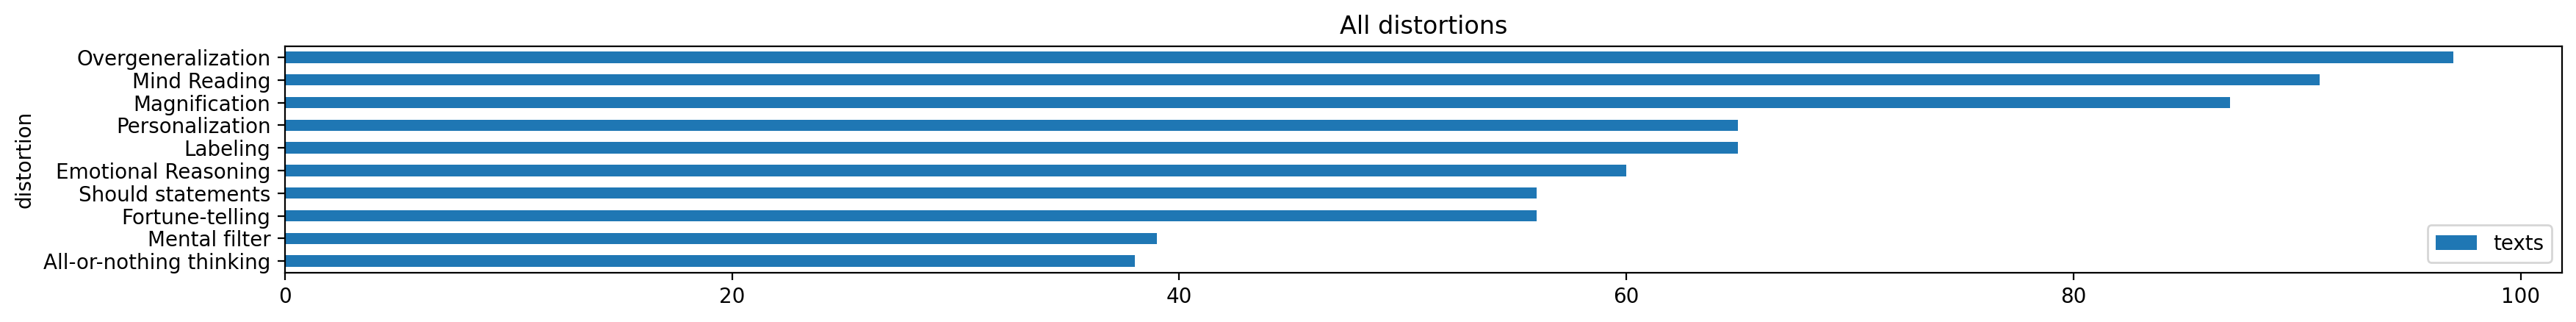

In [8]:
dists = {}
for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion)
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion)
        for d in ground_distortions:
            dictcount(dists,d)
        
plot_dict(
    dists,
    labels="distortion",
    values="texts",
    title="All distortions",
    head=20
)

In [4]:
df3s = [ df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy()]

row_n = 0 
for _, row in df3.iterrows():
    r3 = row_n % 3
    row_n += 1
    df = df3s[r3]
    df.loc[len(df)] = row

print(len(df3))
for df in df3s:
    print(len(df), len(df)*2)

2530
844 1688
843 1686
843 1686


In [5]:
all_metrics = ['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Labeling',
          'Mind_Reading','Personalization','Emotional_Reasoning','Magnification','Should_statements']

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_test(actual_distortions,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in actual_distortions else False
    return dic

def our_evaluator_tm(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in metrics and metrics[m] > threshold else False
    return dic

def our_evaluator_true(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic
    
def our_evaluator_false(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic

def our_evaluator_random(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = random.choice([True, False])
    return dic

def dictval(dic,key,val):
    return dic[key] if key in dic else val 

def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df(df,tm,evaluator,threshold,debug=False):
    true_positives = {}
    true_negatives = {}
    false_positives = {}
    false_negatives = {}
    f1 = {}
    acc = {}
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion)
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion)

        if evaluator == our_evaluator_test:
            distortions_by_metric = evaluator(ground_distortions,text,threshold) #hack to test metrics
        else:
            distortions_by_metric = evaluator(tm,text,threshold)
        
        for metric in distortions_by_metric:
            our_distortion = distortions_by_metric[metric]
            if (metric in ground_distortions) and our_distortion == True:
                dictcount(true_positives,metric)
            if (not metric in ground_distortions) and our_distortion == True:
                dictcount(false_positives,metric)
            if (not metric in ground_distortions) and our_distortion == False:
                dictcount(true_negatives,metric)
            if (metric in ground_distortions) and our_distortion == False:
                dictcount(false_negatives,metric)

    if debug:
        print(true_positives)
        print(true_negatives)
        print(false_positives)
        print(false_negatives)
    
    for metric in all_metrics:
        f1[metric]= f1_from_counts(dictval(true_positives,metric,0), dictval(true_negatives,metric,0), 
                                   dictval(false_positives,metric,0), dictval(false_negatives,metric,0))
        acc[metric] = (dictval(true_positives,metric,0) + dictval(true_negatives,metric,0)) / len(df)
    
    return f1, acc


def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()


In [6]:
models = {}

models['Ours new (multi-class, joint), log'] = TextMetrics(language_metrics('',all_metrics,
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class, joint), no log'] = TextMetrics(language_metrics('',all_metrics,
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


{'Personalization': 202, 'Labeling': 203, 'Fortune-telling': 210, 'Magnification': 245, 'Overgeneralization': 277}
{'All-or-nothing_thinking': 2530, 'Fortune-telling': 2320, 'Mental_filter': 2530, 'Overgeneralization': 2253, 'Labeling': 2327, 'Mind_Reading': 2530, 'Emotional_Reasoning': 2530, 'Magnification': 2285, 'Should_statements': 2530, 'Personalization': 2328}
{}
{}


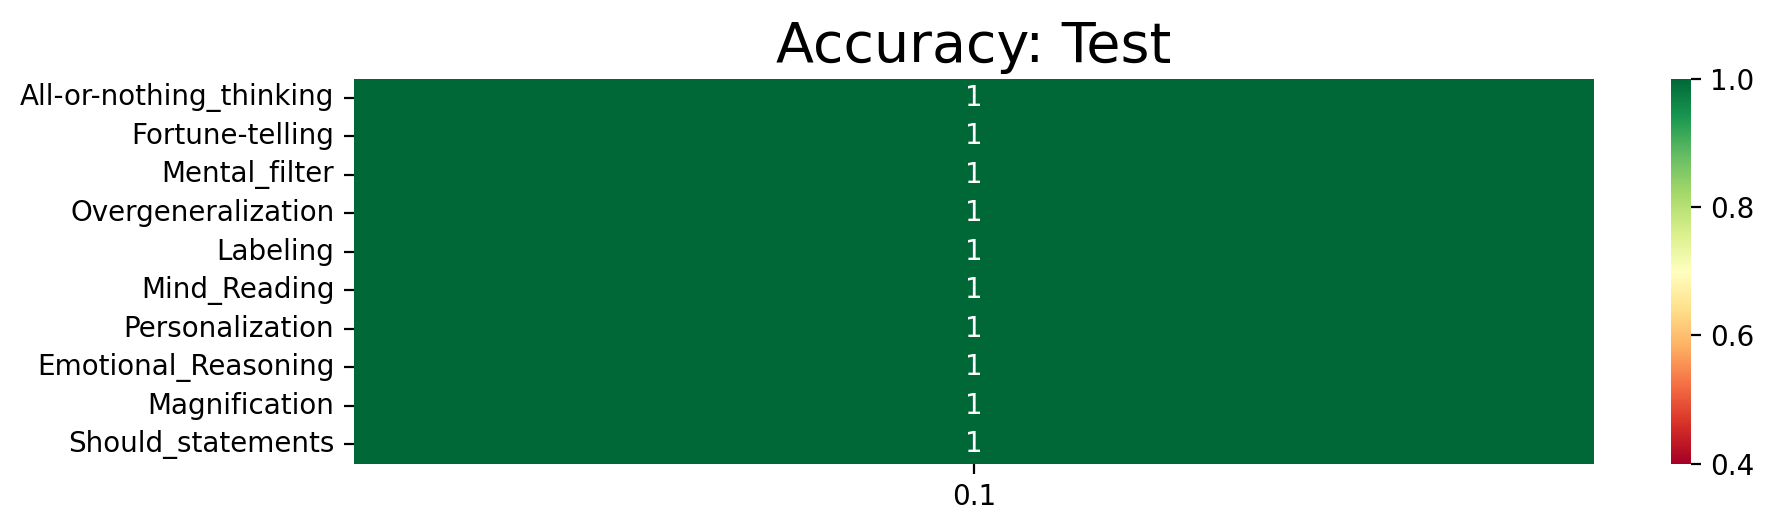

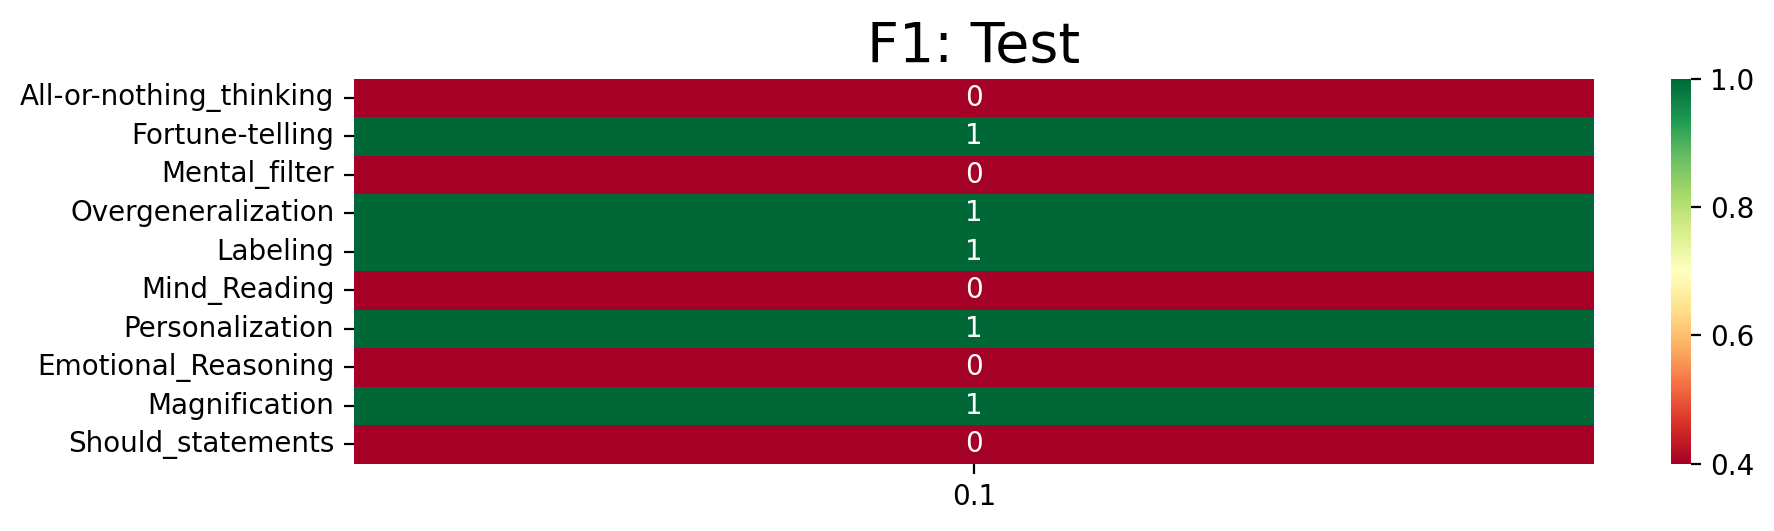

In [10]:
#thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
thresholds = [0.1]

evaluators = {
    'Ours new (multi-class, joint), log': our_evaluator_tm,
    'Ours new (multi-class, joint), no log': our_evaluator_tm,
    'Const(True)': our_evaluator_true,
    'Const(False)': our_evaluator_false,
    'Random': our_evaluator_random,
    'Test': our_evaluator_test,
}

#for model in ['Ours new (multi-class, joint), log', 'Ours new (multi-class, joint), no log', 'Const(True)','Const(False)','Random']:
#for model in ['Const(True)','Const(False)','Random']:
for model in ['Test']:
    f1s = [[] for i in range(len(all_metrics))]
    accs = [[] for i in range(len(all_metrics))]
    evaluator = evaluators[model]
    for t in thresholds:
        f1, acc = evaluate_tm_df(df3,models[model] if model in models else None,evaluator,t,debug=True)
        mi = 0
        for metric in all_metrics:
            f1s[mi].append(f1[metric])
            accs[mi].append(acc[metric])
            mi += 1
    
    matrix_plot(all_metrics, thresholds, accs, 1.0, title = f'Accuracy: {model}', 
                vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)
    
    matrix_plot(all_metrics, thresholds, f1s, 1.0, title = f'F1: {model}', 
                vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)
